In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

from scipy import stats
import pickle
from collections import defaultdict
from statsmodels.stats.multitest import multipletests

%matplotlib inline

# Annotation

It is known that Adar1 works in almost all tissues of the body, but the factors regulating its activity \
in different tissues are almost unknown. The main idea of the work was to find a link between human gene expression \
and RNA editing activity, i.e. Adar1 activity.

In [2]:
ROOT = Path().cwd()
TPM = ROOT / "tpm"
REDI = ROOT / "redi"
GTEX = ROOT / "gtex"
RESULTS = ROOT / "results"

# Preparing

## AEI

http://srv00.recas.ba.infn.it/cgi/atlas/searchSample.py?query9=hg&query10=hg19&query1=&query2=GTEx&query3=normal&query4=bulk&aei1=&aei2=&adr1=&adr2=&adr21=&adr22=&adr31=&adr32=

In [3]:
DTYPES = {
    'Sample': str,
    'WGS/WES': str,
    'Body Site': str,
    'AEI': np.float32,
    'ADAR': np.float32,
    'ADARB1': np.float32,
    'ADARB2': np.float32
}

In [4]:
file = REDI / "REDIportal 22.16.59.csv"
aei_df = pd.read_csv(
        file,
        chunksize=1000000,
        dtype=DTYPES,
        usecols=DTYPES.keys()
    )
aei_df = pd.concat(aei_df)

In [5]:
aei_df.head()

,Sample,WGS/WES,Body Site,AEI,ADAR,ADARB1,ADARB2
0,SRR1068687,SRR8233673,Esophagus - Gastroesophageal Junction,1.945,107.768997,110.507004,0.661
1,SRR1068788,SRR8233590,Testis,1.044,64.807999,8.449000,2.666
2,SRR1068808,SRR8233539,Cells - Transformed fibroblasts,1.228,135.679993,66.248001,0.000
3,SRR1068832,SRR8233604,Artery - Coronary,1.331,70.764000,57.324001,0.030
4,SRR1068855,SRR8233664,Muscle - Skeletal,0.709,7.915000,6.297000,0.052


In [6]:
aei_df.shape

(9642, 7)

In [7]:
aei_df.isna().sum()

Sample          0
WGS/WES      1100
Body Site       0
AEI             0
ADAR            0
ADARB1          0
ADARB2          0
dtype: int64

In [8]:
aei_df = aei_df.drop_duplicates().drop_duplicates(subset=["Sample"]).dropna(subset=['Sample','Body Site','AEI'])
aei_df.head()

,Sample,WGS/WES,Body Site,AEI,ADAR,ADARB1,ADARB2
0,SRR1068687,SRR8233673,Esophagus - Gastroesophageal Junction,1.945,107.768997,110.507004,0.661
1,SRR1068788,SRR8233590,Testis,1.044,64.807999,8.449000,2.666
2,SRR1068808,SRR8233539,Cells - Transformed fibroblasts,1.228,135.679993,66.248001,0.000
3,SRR1068832,SRR8233604,Artery - Coronary,1.331,70.764000,57.324001,0.030
4,SRR1068855,SRR8233664,Muscle - Skeletal,0.709,7.915000,6.297000,0.052


In [9]:
aei_df.shape

(9642, 7)

In [10]:
len(set(aei_df["Sample"]))

9642

In [11]:
len(set(aei_df["WGS/WES"]))

480

## Tpm

https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz

In [12]:
DTYPES = {
    'Sample': str,
    'WGS/WES': str,
    'Body Site': str,
    'AEI': np.float32,
    'ADAR': np.float32,
    'ADARB1': np.float32,
    'ADARB2': np.float32
}

In [ ]:
file = TPM / "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
tpm = pd.read_csv(
        file,
        chunksize=1000000,
        skiprows=2,
        index_col=[0,1],
        sep="\t",
        on_bad_lines="skip"
    )
tpm = pd.concat(tpm)

In [ ]:
tpm = tpm.astype(np.float32)

In [ ]:
tpm.head()

In [ ]:
tpm.shape

In [ ]:
tpm.isna().sum().sum()

In [18]:
tpm = tpm.reset_index().drop_duplicates().drop_duplicates(subset=["Name","Description"]).dropna(subset=["Name"])

In [19]:
tpm.shape

(56200, 17384)

In [20]:
ens_name_genmap = tpm[["Name","Description"]].set_index("Name").to_dict("dict")["Description"]

In [21]:
[(i, j) for (i, j) in ens_name_genmap.items() if "ADAR" in j]

[('ENSG00000160710.15', 'ADAR'),
 ('ENSG00000185736.15', 'ADARB2'),
 ('ENSG00000205696.4', 'ADARB2-AS1'),
 ('ENSG00000197381.15', 'ADARB1')]

In [22]:
tpm_t = tpm.T.reset_index()

In [23]:
tpm_t.columns = tpm_t.iloc[0,:]
tpm_t = tpm_t.drop(labels=[0,1], axis=0)

In [24]:
tpm_t.head()

,Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
2,GTEX-1117F-0226-SM-5GZZ7,0.0,8.764,0.0,0.07187,0.0,0.0,0.06621,0.0,0.0,...,12400.0,0.0,0.0,0.0,2928.0,3799.0,16.24,6938.0,0.943,0.0
3,GTEX-1117F-0426-SM-5EGHI,0.0,3.861,0.0,0.0,0.0,0.056,0.05004,0.1025,0.04574,...,34030.0,0.0,0.0,0.0,10400.0,14750.0,44.310001,26310.0,6.414,6.226
4,GTEX-1117F-0526-SM-5EGHJ,0.0,7.349,1.004,0.0,0.0,0.0,0.0,0.07434,0.09953,...,13820.0,0.9891,0.0,0.0,4471.0,6728.0,23.74,8455.0,1.034,1.004
5,GTEX-1117F-0626-SM-5N9CS,0.0,11.07,0.0,0.06761,0.0,0.0,0.0,0.0,0.0,...,11990.0,0.0,0.0,0.0,1237.0,817.299988,0.0,8799.0,0.0,0.0
6,GTEX-1117F-0726-SM-5GIEN,0.0,3.306,0.0,0.0,0.0,0.0,0.0,0.04233,0.07556,...,69350.0,0.5631,0.0,0.5473,7780.0,7051.0,2.252,29170.0,0.0,2.857


## Link table

In [25]:
file = GTEX / "SRR_GTEX.txt"
sra_gtex = pd.read_csv(
        file,
        chunksize=1000000,
        usecols=["Run", "biospecimen_repository_sample_id"]
    )
sra_gtex = pd.concat(sra_gtex)

In [26]:
sra_gtex.head()

,Run,biospecimen_repository_sample_id
0,SRR8227334,GTEX-1C64N-0126-SM-793D7
1,SRR8227335,GTEX-1C64N-1026-SM-79ONM
2,SRR8227336,GTEX-1C64N-2826-SM-7IGP5
3,SRR8227337,GTEX-1C64N-2926-SM-79OLM
4,SRR8227338,GTEX-1C64N-3126-SM-79OO3


In [27]:
sra_gtex.shape

(24455, 2)

In [28]:
sra_gtex.isna()['Run'].sum()

0

In [29]:
sra_gtex = sra_gtex.drop_duplicates("Run")

In [30]:
sra_gtex.shape

(24455, 2)

In [31]:
sra_gtex.groupby(by="biospecimen_repository_sample_id").aggregate({"Run":"count"}).sort_values(by="Run", ascending=False)

,Run
biospecimen_repository_sample_id,
GTEX-X3Y1-0226-SM-3P5Z5,4
GTEX-P78B-1326-SM-3P611,4
GTEX-PLZ4-1626-SM-3P618,4
GTEX-X4EP-3226-SM-3P5YR,4
GTEX-X4EP-3026-SM-3P5YP,4
...,...
GTEX-18465-2926-SM-7KFSE,1
GTEX-18465-2826-SM-7LT9J,1
GTEX-18465-2726-SM-7LT9I,1


In [32]:
sra_gtex.groupby(by="Run").aggregate({"biospecimen_repository_sample_id":"count"}).sort_values(by="biospecimen_repository_sample_id", ascending=False)

,biospecimen_repository_sample_id
Run,
SRR1068687,1
SRR8225610,1
SRR8225619,1
SRR8225618,1
SRR8225617,1
...,...
SRR2165567,1
SRR2165527,1
SRR2165523,1


## Merge

In [33]:
sra_gtex

,Run,biospecimen_repository_sample_id
0,SRR8227334,GTEX-1C64N-0126-SM-793D7
1,SRR8227335,GTEX-1C64N-1026-SM-79ONM
2,SRR8227336,GTEX-1C64N-2826-SM-7IGP5
3,SRR8227337,GTEX-1C64N-2926-SM-79OLM
4,SRR8227338,GTEX-1C64N-3126-SM-79OO3
...,...,...
24450,SRR2185018,GTEX-T5JC-0626-SM-5S2RW
24451,SRR2185057,GTEX-S32W-0004-SM-5S2SG
24452,SRR2185097,GTEX-T5JC-0826-SM-5S2SN
24453,SRR2185233,GTEX-S32W-0626-SM-5S2TC


In [34]:
df_merged = pd.merge(
    aei_df, sra_gtex[["Run", "biospecimen_repository_sample_id"]],
    left_on='Sample',
    right_on='Run'
)

In [35]:
df_merged

,Sample,WGS/WES,Body Site,AEI,ADAR,ADARB1,ADARB2,Run,biospecimen_repository_sample_id
0,SRR1068687,SRR8233673,Esophagus - Gastroesophageal Junction,1.945,107.768997,110.507004,0.661,SRR1068687,GTEX-XXEK-0526-SM-4BRWD
1,SRR1068788,SRR8233590,Testis,1.044,64.807999,8.449000,2.666,SRR1068788,GTEX-TKQ2-1526-SM-4DXUN
2,SRR1068808,SRR8233539,Cells - Transformed fibroblasts,1.228,135.679993,66.248001,0.000,SRR1068808,GTEX-QV44-0008-SM-447AX
3,SRR1068832,SRR8233604,Artery - Coronary,1.331,70.764000,57.324001,0.030,SRR1068832,GTEX-UJMC-0426-SM-4IHJF
4,SRR1068855,SRR8233664,Muscle - Skeletal,0.709,7.915000,6.297000,0.052,SRR1068855,GTEX-XOTO-0526-SM-4B662
...,...,...,...,...,...,...,...,...,...
9637,SRR821846,SRR8233504,Artery - Coronary,1.159,63.457001,25.594999,0.429,SRR821846,GTEX-P4PP-3026-SM-3P61O
9638,SRR823967,NaN,Cells - Leukemia cell line (CML),0.993,88.030998,6.687000,0.015,SRR823967,K-562-SM-3NMDG
9639,SRR823991,NaN,Cells - Leukemia cell line (CML),0.963,84.779999,6.055000,0.038,SRR823991,K-562-SM-3NMAP
9640,SRR824015,NaN,Cells - Leukemia cell line (CML),0.929,71.894997,5.807000,0.006,SRR824015,K-562-SM-3NB3I


## Table to ML

In [36]:
df_final = pd.merge(
    tpm_t, df_merged[["Sample", "biospecimen_repository_sample_id", "Body Site", "AEI"]],
    left_on='Name',
    right_on='biospecimen_repository_sample_id'
)

In [37]:
df_final

,Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,...,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,Sample,biospecimen_repository_sample_id,Body Site,AEI
0,GTEX-1117F-0226-SM-5GZZ7,0.0,8.764,0.0,0.07187,0.0,0.0,0.06621,0.0,0.0,...,2928.0,3799.0,16.24,6938.0,0.943,0.0,SRR1455038,GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,1.905
1,GTEX-1117F-0426-SM-5EGHI,0.0,3.861,0.0,0.0,0.0,0.056,0.05004,0.1025,0.04574,...,10400.0,14750.0,44.310001,26310.0,6.414,6.226,SRR1309070,GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,0.740
2,GTEX-1117F-0526-SM-5EGHJ,0.0,7.349,1.004,0.0,0.0,0.0,0.0,0.07434,0.09953,...,4471.0,6728.0,23.74,8455.0,1.034,1.004,SRR1500555,GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,2.351
3,GTEX-1117F-0626-SM-5N9CS,0.0,11.07,0.0,0.06761,0.0,0.0,0.0,0.0,0.0,...,1237.0,817.299988,0.0,8799.0,0.0,0.0,SRR1317257,GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,2.382
4,GTEX-1117F-0726-SM-5GIEN,0.0,3.306,0.0,0.0,0.0,0.0,0.0,0.04233,0.07556,...,7780.0,7051.0,2.252,29170.0,0.0,2.857,SRR1368794,GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,2.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,GTEX-ZZPU-2126-SM-5EGIU,0.0,4.023,0.0,0.1435,0.0,0.0,0.0,0.06767,0.0604,...,4345.0,4290.0,15.31,20620.0,0.0,2.741,SRR1396208,GTEX-ZZPU-2126-SM-5EGIU,Ovary,1.488
8648,GTEX-ZZPU-2226-SM-5EGIV,0.0,1.922,0.0,0.0,0.0,0.0,0.1108,0.1135,0.0,...,2872.0,2446.0,4.53,16820.0,0.0,2.298,SRR1445920,GTEX-ZZPU-2226-SM-5EGIV,Vagina,1.245
8649,GTEX-ZZPU-2426-SM-5E44I,0.0,2.857,0.0,0.05216,0.0,0.0,0.0961,0.0,0.1098,...,9111.0,16250.0,58.259998,19200.0,0.0,2.657,SRR1389546,GTEX-ZZPU-2426-SM-5E44I,Artery - Tibial,1.797
8650,GTEX-ZZPU-2626-SM-5E45Y,0.01965,0.8696,0.0,0.0,0.0,0.04044,0.03614,0.148,0.01651,...,14880.0,19660.0,59.07,36670.0,47.860001,4.496,SRR1350832,GTEX-ZZPU-2626-SM-5E45Y,Muscle - Skeletal,0.476


In [38]:
df_final = df_final.drop(labels=["Sample", "biospecimen_repository_sample_id"], axis=1)

In [39]:
df_final.head(2)

,Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,...,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,Body Site,AEI
0,GTEX-1117F-0226-SM-5GZZ7,0.0,8.764,0.0,0.07187,0.0,0.0,0.06621,0.0,0.0,...,0.0,0.0,2928.0,3799.0,16.24,6938.0,0.943,0.0,Adipose - Subcutaneous,1.905
1,GTEX-1117F-0426-SM-5EGHI,0.0,3.861,0.0,0.0,0.0,0.056,0.05004,0.1025,0.04574,...,0.0,0.0,10400.0,14750.0,44.310001,26310.0,6.414,6.226,Muscle - Skeletal,0.740


In [40]:
df_final['ENSG00000160710.15']#ADAR

0        91.959999
1        16.139999
2        95.339996
3        90.849998
4        32.900002
           ...    
8647    108.599998
8648         49.77
8649     75.199997
8650         14.85
8651     73.279999
Name: ENSG00000160710.15, Length: 8652, dtype: object

# AEI vs TPM

ENSG00000160710.15 - ADAR

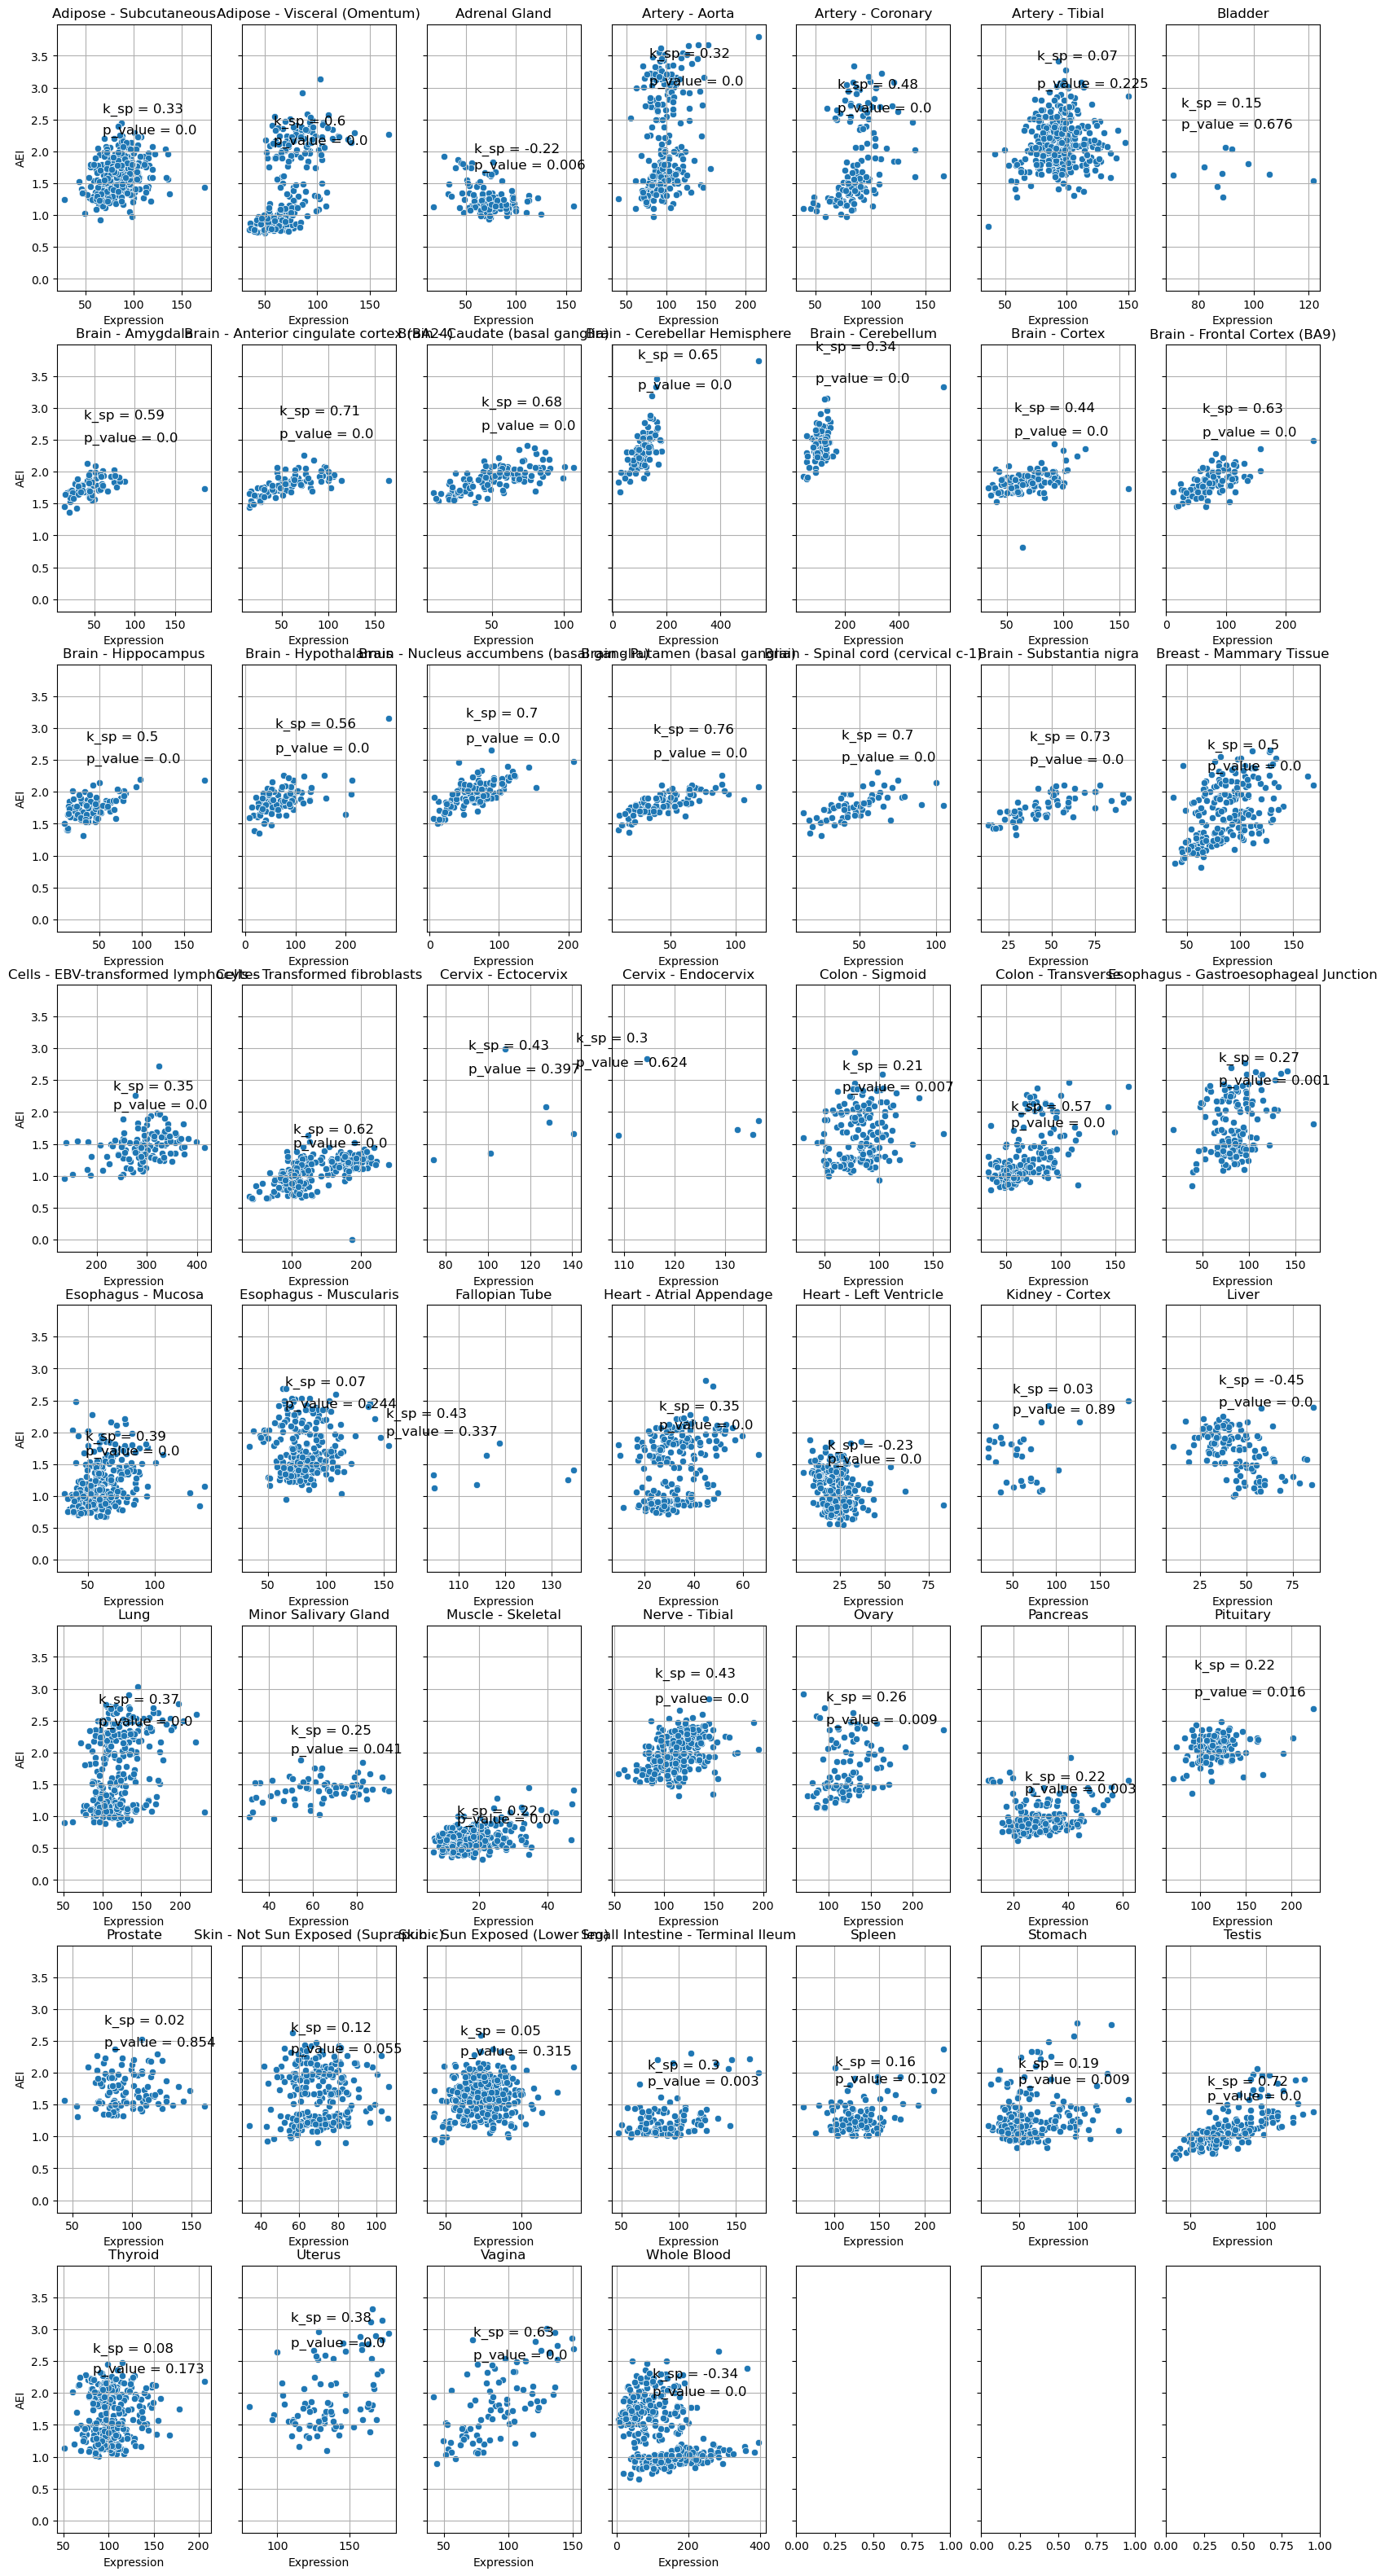

In [41]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(20, 40), sharey=True)
corr_df = defaultdict(list)
weight_dict = {}
for i, (name, body_site) in enumerate(df_final[["ENSG00000160710.15", "AEI", "Body Site"]].groupby(by="Body Site")):
    x = body_site['ENSG00000160710.15']
    y = body_site['AEI']
    sns.scatterplot(x=x, y=y, ax=axes[int(i / 7), i % 7])
    k_sp, p_value = stats.spearmanr(x, y, alternative='two-sided')
    corr_df["body_site"].append(name)
    corr_df["k_sp"].append(k_sp)
    corr_df["p-value"].append(p_value)
    axes[i // 7, i % 7].text(np.mean(x)*0.8, np.mean(y)*1.6, f'k_sp = {round(k_sp, 2)}', size=12)
    axes[i // 7, i % 7].text(np.mean(x)*0.8, np.mean(y)*1.4, f'p_value = {round(p_value, 3)}', size=12)
    axes[i // 7, i % 7].set_title(f'{name}')
    axes[i // 7, i % 7].set_xlabel('Expression')
    axes[i // 7, i % 7].set_ylabel('AEI')
    axes[i // 7, i % 7].grid() 
    
    weight_dict[name] = body_site.shape[0]

In [42]:
corr_df = pd.DataFrame(corr_df)

In [43]:
pval_adj = multipletests(corr_df['p-value'], alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
corr_df['p-value_adj'] = pval_adj[1]

In [44]:
alpha = 10**-3
corr_df["significant"] = corr_df["p-value_adj"].apply(lambda x: 1 if x <= alpha else 0.3)
corr_df["color"] = corr_df["body_site"].apply(lambda x: "o" if (x == "Testis" or x == "Liver") else "g")

In [45]:
corr_df

,body_site,k_sp,p-value,p-value_adj,significant,color
0,Adipose - Subcutaneous,0.327817,1.248335e-09,3.482198e-09,1.0,g
1,Adipose - Visceral (Omentum),0.600392,1.588164e-23,2.805757e-22,1.0,g
2,Adrenal Gland,-0.223604,5.619917e-03,8.273767e-03,0.3,g
3,Artery - Aorta,0.315458,7.944709e-07,1.559517e-06,1.0,g
4,Artery - Coronary,0.476811,7.484710e-09,1.888998e-08,1.0,g
5,Artery - Tibial,0.066153,2.251206e-01,2.651420e-01,0.3,g
6,Bladder,0.151515,6.760652e-01,7.025775e-01,0.3,g
7,Brain - Amygdala,0.593386,1.615043e-08,3.890786e-08,1.0,g
8,Brain - Anterior cingulate cortex (BA24),0.714886,1.067123e-14,6.284169e-14,1.0,g
9,Brain - Caudate (basal ganglia),0.679681,1.400910e-17,1.060689e-16,1.0,g


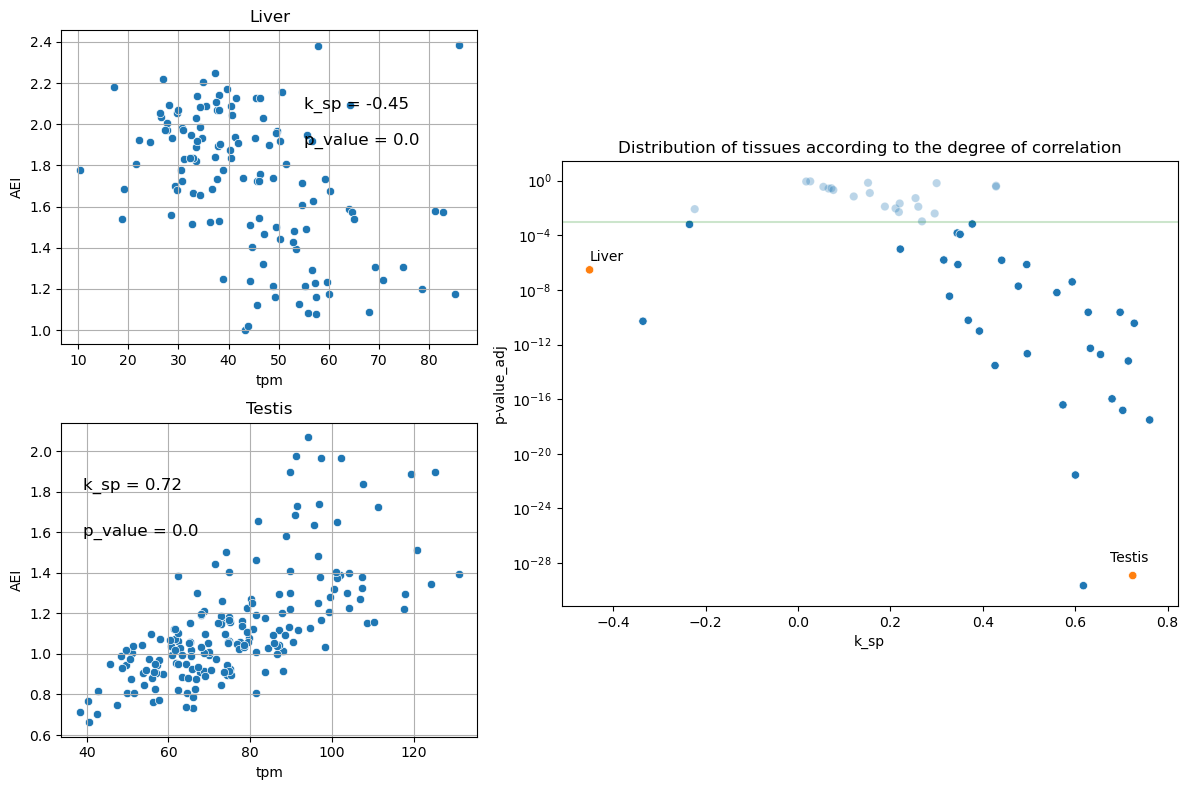

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(6, 12)

ax0 = fig.add_subplot(gs[:3, :5])
subdf = df_final[df_final["Body Site"] == "Liver"][["ENSG00000160710.15", "AEI", "Body Site"]]
x = subdf["ENSG00000160710.15"]
y = subdf["AEI"]
sns.scatterplot(x=x, y=y, ax=ax0)
k_sp, p_value = stats.spearmanr(x, y, alternative='two-sided')
ax0.text(55, np.mean(y)*1.2, f'k_sp = {round(k_sp, 2)}', size=12)
ax0.text(55, np.mean(y)*1.1, f'p_value = {round(p_value, 3)}', size=12)
ax0.set_title('Liver')
ax0.set_xlabel('tpm')
ax0.set_ylabel('AEI')
ax0.grid() 

ax1 = fig.add_subplot(gs[3:, :5])
subdf = df_final[df_final["Body Site"] == "Testis"][["ENSG00000160710.15", "AEI", "Body Site"]]
x = subdf["ENSG00000160710.15"]
y = subdf["AEI"]
sns.scatterplot(x=x, y=y, ax=ax1)
k_sp, p_value = stats.spearmanr(x, y, alternative='two-sided')
ax1.text(39, np.mean(y)*1.6, f'k_sp = {round(k_sp, 2)}', size=12)
ax1.text(39, np.mean(y)*1.4, f'p_value = {round(p_value, 3)}', size=12)
ax1.set_title('Testis')
ax1.set_xlabel('tpm')
ax1.set_ylabel('AEI')
ax1.grid() 

ax2 = fig.add_subplot(gs[1:5, 5:])
sns.scatterplot(data=corr_df, x="k_sp", y="p-value_adj", hue=corr_df["color"].to_list(), alpha=corr_df["significant"], ax=ax2)
ax2.set(yscale="log")
plt.axhline(y=0.001, xmin=0, xmax=1, color='g', alpha=0.2)
ax2.set_title('Distribution of tissues according to the degree of correlation')
plt.text(x=corr_df.loc[48, "k_sp"]-0.05, y=corr_df.loc[48, "p-value_adj"]+1e-28, s='Testis')
plt.text(x=corr_df.loc[34, "k_sp"], y=corr_df.loc[34, "p-value_adj"]+1e-6, s='Liver')
legend = ax2.legend()
legend.remove()
plt.show()

# ML

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, r2_score

from joblib import Parallel, delayed

In [48]:
def ln_regr(model, n=3):
    importance_for_k_fold = []
    kf = KFold(n_splits=n, shuffle=True, random_state=27)
    for i, (train_index, test_index) in enumerate(kf.split(features)):
        trainX, trainY, trainW = features.loc[train_index,:], labels[train_index], df_final["Body_site_weight"][train_index]
        testX, testY, testW = features.loc[test_index,:], labels[test_index], df_final["Body_site_weight"][test_index]
        model.fit(trainX, trainY, sample_weight=trainW)
        importance = model.coef_
        
        trainY_pred = model.predict(trainX)
        testY_pred = model.predict(testX)
        print('[0] Linear Regression Train Error R2: ',r2_score(trainY,trainY_pred))
        print('[0] Linear Regression Test Error R2: ',r2_score(testY,testY_pred))
        print("\n")
        importance_for_k_fold.append(importance)
    average_importance = sum(importance_for_k_fold) / n
    return average_importance

In [49]:
df_final.head()

,Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,...,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,Body Site,AEI
0,GTEX-1117F-0226-SM-5GZZ7,0.0,8.764,0.0,0.07187,0.0,0.0,0.06621,0.0,0.0,...,0.0,0.0,2928.0,3799.0,16.24,6938.0,0.943,0.0,Adipose - Subcutaneous,1.905
1,GTEX-1117F-0426-SM-5EGHI,0.0,3.861,0.0,0.0,0.0,0.056,0.05004,0.1025,0.04574,...,0.0,0.0,10400.0,14750.0,44.310001,26310.0,6.414,6.226,Muscle - Skeletal,0.740
2,GTEX-1117F-0526-SM-5EGHJ,0.0,7.349,1.004,0.0,0.0,0.0,0.0,0.07434,0.09953,...,0.0,0.0,4471.0,6728.0,23.74,8455.0,1.034,1.004,Artery - Tibial,2.351
3,GTEX-1117F-0626-SM-5N9CS,0.0,11.07,0.0,0.06761,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1237.0,817.299988,0.0,8799.0,0.0,0.0,Artery - Coronary,2.382
4,GTEX-1117F-0726-SM-5GIEN,0.0,3.306,0.0,0.0,0.0,0.0,0.0,0.04233,0.07556,...,0.0,0.5473,7780.0,7051.0,2.252,29170.0,0.0,2.857,Heart - Atrial Appendage,2.210


In [50]:
df = df_final.drop(['Name', 'Body Site'], axis=1) 
scaled_df = StandardScaler().fit_transform(df.values)
scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)

In [51]:
scaled_df

,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3,...,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,AEI
0,-0.304671,1.476388,-0.159841,1.321627,-0.460644,-0.735175,0.113835,-0.557817,-0.370573,-0.201035,...,-0.095625,-0.153937,-0.116891,-0.824685,-0.653968,-0.327490,-1.272260,-0.085354,-0.170327,0.597398
1,-0.304671,-0.134966,-0.159841,-0.580580,-0.460644,0.253911,-0.126401,0.115934,-0.068513,-0.256088,...,-0.095625,-0.153937,-0.116891,0.899799,1.067903,0.167764,0.342986,0.030360,-0.010364,-1.556388
2,-0.304671,1.011353,8.077967,-0.580580,-0.460644,-0.735175,-0.869838,-0.069167,0.286709,-0.289548,...,-0.075844,-0.153937,-0.116891,-0.468572,-0.193429,-0.195164,-1.145772,-0.083429,-0.144532,1.421938
3,-0.304671,2.234248,-0.159841,1.208876,-0.460644,-0.735175,-0.869838,-0.557817,-0.370573,-0.289548,...,-0.095625,-0.153937,-0.116891,-1.214956,-1.122793,-0.614021,-1.117089,-0.105299,-0.170327,1.479249
4,-0.304671,-0.317365,-0.159841,-0.580580,-0.460644,-0.735175,-0.869838,-0.279574,0.128415,-0.289548,...,-0.084363,-0.153937,-0.107911,0.295122,-0.142643,-0.574288,0.581454,-0.105299,-0.096923,1.161265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,-0.304671,-0.081725,-0.159841,3.217481,-0.460644,-0.735175,-0.869838,-0.113010,0.028300,0.549788,...,-0.023609,-0.086539,-0.116891,-0.497652,-0.576766,-0.343898,-0.131449,-0.105299,-0.099903,-0.173528
8648,-0.304671,-0.772212,-0.159841,-0.580580,-0.460644,-0.735175,0.776303,0.188239,-0.370573,0.377440,...,-0.095625,-0.153937,-0.116891,-0.837610,-0.866706,-0.534096,-0.448294,-0.105299,-0.111285,-0.622773
8649,-0.304671,-0.464927,-0.159841,0.799956,-0.460644,-0.735175,0.557907,-0.557817,0.354531,-0.161050,...,-0.082534,-0.104934,-0.116891,0.602307,1.303754,0.413891,-0.249849,-0.105299,-0.102061,0.397734
8650,0.081845,-1.118080,-0.159841,-0.580580,-0.460644,-0.020914,-0.332911,0.415014,-0.261544,-0.289548,...,-0.075934,-0.006532,-0.116891,1.933751,1.839922,0.428182,1.206807,0.906957,-0.054812,-2.044456


In [52]:
features = scaled_df.drop('AEI', axis=1) 
labels = scaled_df['AEI']

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size=0.4, random_state=50)

In [54]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, Y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [55]:
rmse_train = mean_squared_error(Y_train,y_train_pred, squared=False)
rmse_test = mean_squared_error(Y_test,y_test_pred, squared=False)
print('[0] Linear Regression Train Error RMSE: ',rmse_train)
print('[0] Linear Regression Train Error R2: ',r2_score(Y_train,y_train_pred))
print('[0] Linear Regression Test Error RMSE: ',rmse_test)
print('[0] Linear Regression Test Error R2: ',r2_score(Y_test,y_test_pred))

[0] Linear Regression Train Error RMSE:  4.801782844042116e-15
[0] Linear Regression Train Error R2:  1.0
[0] Linear Regression Test Error RMSE:  0.22174513283052197
[0] Linear Regression Test Error R2:  0.9519885641105692


Text(0, 0.5, 'Predicted AEI')

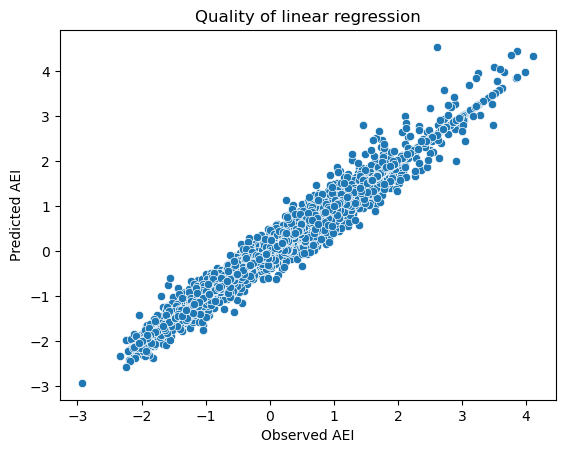

In [56]:
predicted_AEI = lr.predict(features)
observed_AEI = labels
ax = sns.scatterplot(x=observed_AEI, y=predicted_AEI, alpha=1)
ax.set_title('Quality of linear regression')
ax.set_xlabel('Observed AEI')
ax.set_ylabel('Predicted AEI')

## Lasso + weight crossval

In [57]:
df_final["Body_site_weight"] = 1 / df_final["Body Site"].apply(lambda x: weight_dict[x])

In [58]:
X_train, X_test, Y_train, Y_test, trainW, testW = train_test_split(features, labels, df_final["Body_site_weight"],
                                                    test_size=0.4, random_state=50)

In [59]:
GRID = {
     ("l1_Lasso", Lasso()): {
         'alpha': np.arange(0, 1.1, 0.1),
         'max_iter': [100, 500, 1000],
         'random_state': [27]
     },
}

In [60]:
RESULTS.mkdir(exist_ok=True)


def job(key, model, grid):
    saveto = RESULTS / f"{key}.pkl"
    if saveto.exists():
        return

    print(f"{key} grid search")
    grid = GridSearchCV(
        model, grid, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=27), n_jobs=-1,
        verbose=100, refit=True
    ).fit(X_train, Y_train, sample_weight=trainW)

    print(f"\t{key} grid finished")

    results = {
        "grid": grid,
    }

    with open(saveto, 'wb') as stream:
        pickle.dump(results, stream)


_ = Parallel(n_jobs=-1, backend='threading')(#'sequential'
    delayed(job)(key, model, grid)
    for (key, model), grid in GRID.items()
)

In [61]:
SUMMARY = {"models": {}}
for path in RESULTS.iterdir():
    with open(path, 'rb') as stream:
        data = pickle.load(stream)
    name = path.name.split('.')[0]
    SUMMARY['models'][name] = data

In [62]:
cv_results = pd.DataFrame(SUMMARY['models']['l1_Lasso']["grid"].cv_results_)
cv_results = cv_results[['param_alpha', 'param_max_iter', 'mean_test_score', 'params']].sort_values(by="param_alpha")
cv_results

,param_alpha,param_max_iter,mean_test_score,params
0,0.0,100,-2761.225425,"{'alpha': 0.0, 'max_iter': 100, 'random_state'..."
1,0.0,500,-19132.443807,"{'alpha': 0.0, 'max_iter': 500, 'random_state'..."
2,0.0,1000,-123237.669373,"{'alpha': 0.0, 'max_iter': 1000, 'random_state..."
3,0.1,100,0.820380,"{'alpha': 0.1, 'max_iter': 100, 'random_state'..."
4,0.1,500,0.820613,"{'alpha': 0.1, 'max_iter': 500, 'random_state'..."
5,0.1,1000,0.820613,"{'alpha': 0.1, 'max_iter': 1000, 'random_state..."
6,0.2,100,0.689942,"{'alpha': 0.2, 'max_iter': 100, 'random_state'..."
7,0.2,500,0.689982,"{'alpha': 0.2, 'max_iter': 500, 'random_state'..."
8,0.2,1000,0.689982,"{'alpha': 0.2, 'max_iter': 1000, 'random_state..."
9,0.3,100,0.562197,"{'alpha': 0.30000000000000004, 'max_iter': 100..."


In [63]:
import eli5
eli5.show_weights(SUMMARY['models']['l1_Lasso']["grid"].best_estimator_, top=-1, feature_names=X_train.columns.tolist())

Weight?,Feature
+0.076,ENSG00000151006.7
+0.070,ENSG00000067601.7
+0.062,ENSG00000143774.16
+0.056,ENSG00000139597.17
+0.049,ENSG00000129158.10
+0.047,ENSG00000177688.6
+0.046,ENSG00000111276.10
+0.044,ENSG00000120324.8
+0.043,ENSG00000270269.1
+0.033,ENSG00000109472.13


In [64]:
importance = SUMMARY['models']['l1_Lasso']["grid"].best_estimator_.coef_
len(np.array(features.columns.tolist())[importance != 0])

59

In [65]:
#alpha = 0.1
average_importance_0_1 = ln_regr(Lasso(**cv_results.iloc[5,:]["params"]), n=3)

[0] Linear Regression Train Error R2:  0.7836424430708513
[0] Linear Regression Test Error R2:  0.7806604160770256


[0] Linear Regression Train Error R2:  0.780877907082788
[0] Linear Regression Test Error R2:  0.7777883292413311


[0] Linear Regression Train Error R2:  0.783527628267128
[0] Linear Regression Test Error R2:  0.7791122319940376




In [66]:
nonzero_genes_0_1 = np.array(features.columns.tolist())[average_importance_0_1 != 0]

In [67]:
len(nonzero_genes_0_1)

63

In [68]:
nonzero_genes_0_1_by_name = [ens_name_genmap[i] for i in nonzero_genes_0_1]
str(nonzero_genes_0_1_by_name)

"['LINC00115', 'HES4', 'RP3-467L1.4', 'PABPC4', 'GUK1', 'RP11-269F20.1', 'CNOT11', 'AC073410.1', 'ITPR1-AS1', 'ESRG', 'PSMD6', 'TRMT10C', 'CD200', 'RP11-71H17.8', 'RPSAP36', 'DCLK2', 'CPE', 'RP11-798M19.6', 'RPSAP70', 'RANBP3L', 'PCDHB10', 'CTC-463A16.1', 'DTNBP1', 'NPM1P37', 'HMGB1P39', 'TRAF3IP2-AS1', 'SUMO4', 'AIMP2', 'RP5-978I12.1', 'RP9P', 'PMS2P4', 'OPLAH', 'RP11-120J1.1', 'RP11-513M16.7', 'RP11-2B6.2', 'RP11-216B9.9', 'SERGEF', 'IMMP1LP1', 'PCBP2-OT1', 'RP11-380L11.4', 'USP12', 'N4BP2L1', 'RP11-165D6.1', 'RP11-157H4.1', 'RP11-894P9.1', 'ZBTB42', 'RP13-487P22.1', 'RP11-345J18.2', 'CTD-2515A14.1', 'PRSS53', 'RP11-63M22.1', 'DDX28', 'MIR22HG', 'RP11-701H16.4', 'C19orf66', 'FASTKD5', 'C22orf24', 'RP5-1000K24.2', 'TMEM164', 'RAB28P5', 'TTTY6B', 'MT-RNR2', 'MT-ND6']"

In [70]:
#alpha = 0.3
average_importance_0_3 = ln_regr(Lasso(**cv_results.iloc[11,:]["params"]), n=3)

[0] Linear Regression Train Error R2:  0.4025637746606058
[0] Linear Regression Test Error R2:  0.40115379658249783


[0] Linear Regression Train Error R2:  0.3891137884722209
[0] Linear Regression Test Error R2:  0.39308259367186726


[0] Linear Regression Train Error R2:  0.39592208949226926
[0] Linear Regression Test Error R2:  0.38767199499252913




In [71]:
nonzero_genes_0_3 = np.array(features.columns.tolist())[average_importance_0_3 != 0]

In [73]:
len(nonzero_genes_0_3)

19

In [74]:
nonzero_genes_0_3_by_name = [ens_name_genmap[i] for i in nonzero_genes_0_3]
str(nonzero_genes_0_3_by_name)

"['LINC00115', 'RP11-269F20.1', 'ITGA9-AS1', 'IGIP', 'LINC01011', 'TRAF3IP2-AS1', 'SUMO4', 'RP11-216B9.9', 'SERGEF', 'RP11-380L11.4', 'N4BP2L1', 'RP11-165D6.1', 'CTA-276F8.1', 'CTD-2515A14.1', 'DDX28', 'CYP2T1P', 'RP11-1114A5.4', 'RAB28P5', 'TTTY6B']"

'N4BP2L1', 'RP11-513M16.7', 'FASTKD5', 'AIMP2': These genes have already been described in the literature as regulators of adar1 activity. \
It is likely that other genes found are not learning artifacts, but potential regulators of adar1 activity.